<a href="https://colab.research.google.com/github/tetsnaga/FantasyFootball/blob/main/Baseline_and_ML_Method_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse
import sys
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import pinv
import torch
from torch import nn
import torch.optim as optim
import os
from tqdm import tqdm

# Mount Google Drive and find file path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset and Splitting

* **Usage:** Run these cells before any of the methods to parse, split, and initialize structures for our data.

* **Output Dimension:** Determine if label and output will be 1 dimensional (Total Fantasy Points) or 5 dimensional (Rushing Yards, Rushing TDs, Receiving Yards, Receiving TDs, Receptions).



## Get player info given index number

> player_idx = 5

> player_info = get_info(player_idx, headers=["RUSHYD", "NAME"])

> complete_player_info = get_info(player_idx)

> X_data = get_info(player_idx, return_type='X')

> y_data = get_info(player_idx, return_type='y')




In [ ]:
def read_data_with_names(filename, dim, remove_outliers=True):
    path = '/content/drive/Shared drives/CSCI467_Final_Project/'
    filename = path + filename
    x_list, y_list, all_data = [], [], []

    with open(filename) as f:
        next(f)  # Skip the first line
        headers = next(f).strip().split('\t')  # Read the second line for headers

        # Create a dictionary mapping headers to their column indexes
        header_to_index = {header: idx for idx, header in enumerate(headers)}

        for line in f:
            data = line.strip().split('\t')

            # Ensure sufficient data is present
            if len(data) < len(headers):
                print(f"Skipping line due to insufficient data: {data}")
                continue

            # Check for outliers if remove_outliers is True
            if remove_outliers and float(data[18]) == 0:  # Checking 19th column (index 18)
                continue

            # Extract player information and stats
            info = data[:4]
            stats = [float(t) for t in data[4:]]

            if dim == 1:
                x_list.append(stats[:8])  # Current season stats
                y_list.append([stats[14]])  # Next season FPTS (list of single element)
            elif dim == 5:
                x_list.append(stats[:8])  # Current season stats
                y_list.append(stats[9:14])  # Next season stats

            # Concatenate info with stats for the all_data list
            all_data.append(info + data[4:])

    return np.array(x_list), np.array(y_list), np.array(all_data), header_to_index


'''
Input:
  - Player Index
  - Headers: Default is all, can specify which headers you want
  - Return Type: Default is all, can specify if you want just X, just y, or all
Output:
  - Player Stats for specified columns (or all columns if not specified)
'''
def get_info(player_indices=None, headers=None, return_type='all', verbose=False):
    # If no indices are provided, use all indices
    if player_indices is None:
        player_indices = range(len(all_data))

    # Handle single index input for backward compatibility
    elif isinstance(player_indices, int):
        player_indices = [player_indices]

    # Initialize a list to collect data for each player index
    data_list = []

    for player_idx in player_indices:
        # Check if the player index is valid
        if player_idx >= len(all_data):
            if verbose:
                print(f"Player index {player_idx} is out of range.")
            continue

        # Collect data based on return_type and headers
        if return_type == 'X':
            if player_idx >= len(X):
                if verbose:
                    print(f"Player index {player_idx} is out of range in X.")
                continue
            if verbose:
                print(f"Player Index: {player_idx} - X Data:")
            data = [X[player_idx][i] for i, header in enumerate(headers or list(head_to_i.keys())[4:12])]
        elif return_type == 'y':
            if player_idx >= len(y):
                if verbose:
                    print(f"Player index {player_idx} is out of range in y.")
                continue
            if verbose:
                print(f"Player Index: {player_idx} - y Data: {y[player_idx]}")
            data = [y[player_idx]]
        else:  # return_type 'all' or unspecified
            if verbose:
                print(f"Player Index: {player_idx}")
            data = [all_data[player_idx][head_to_i[header]] for header in headers or head_to_i.keys()]

        # Print the data if verbose is True
        if verbose:
            for header, value in zip(headers or head_to_i.keys(), data):
                print(f"{header}: {value}")

        # Append the collected data to the data_list
        data_list.append(data)

    # Convert data_list to a 2D numpy array and return
    return np.array(data_list)

In [ ]:
# Read in data along with player information
X, y, all_data, head_to_i = read_data_with_names('RB_Stats_Master.tsv', dim=1)  # or dim=5

print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")
print("TESTING")
print(f"X Index 20: {X[20]}")
print(f"y Index 20: {y[20]}")

# Combine X, y, and all_data for joint shuffling
combined = list(zip(X, y, all_data))
np.random.seed(230)
np.random.shuffle(combined)

# Unzip them back
X, y, all_data = zip(*combined)
X, y = np.array(X), np.array(y)

# Split into train, dev, and test sets
split_1 = int(0.8 * len(X))
split_2 = int(0.9 * len(X))
X_train, y_train, player_info_train = X[:split_1], y[:split_1], all_data[:split_1]
X_dev, y_dev, player_info_dev = X[split_1:split_2], y[split_1:split_2], all_data[split_1:split_2]
X_test, y_test, player_info_test = X[split_2:], y[split_2:], all_data[split_2:]

X.shape: (381, 8)
y.shape: (381, 1)
TESTING
X Index 20: [ 17. 188. 870.   7.  50.  40. 228.   1.]
y Index 20: [165.]


# Sample Figure: Current Season Points vs Next Season Points

Scatterplot of players and the relationship between fantasy points in adjacent seasons. Points are labeled if players dropped 150 points in a season, gained 200 in a season, or surpassed 350 total for either season.

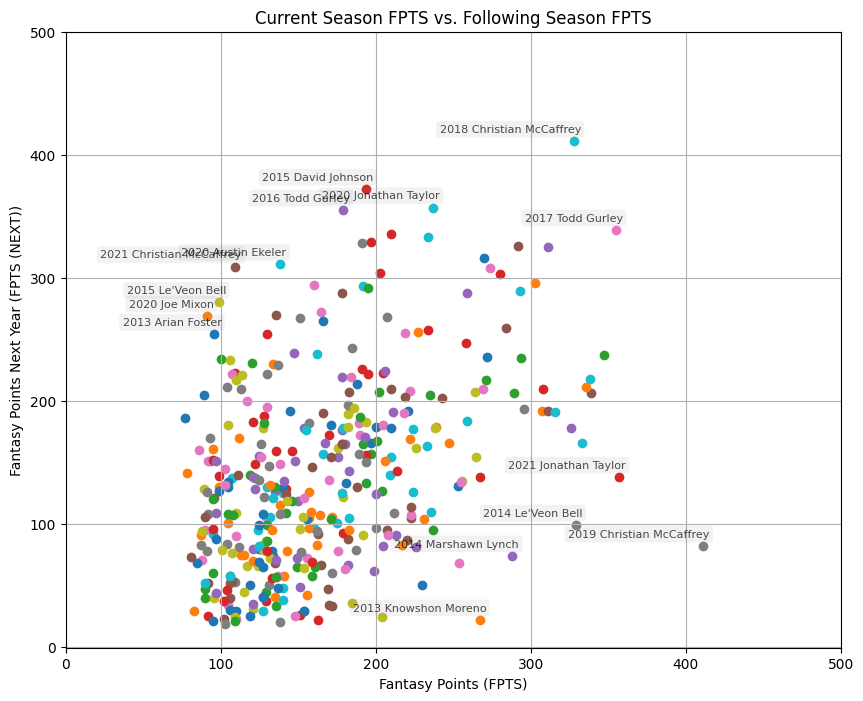

In [ ]:
# Retrieve data for specific player indices
player_data = get_info(headers=["CURRENT YEAR", "NAME", "FPTS", "FPTS (NEXT)"])
# Extract headers for each player
year = player_data[:, 0]
names = player_data[:, 1]  # Assuming "NAME" is in the first column
yearname = [y + " " + n for y, n in zip(year, names)]
fpts = player_data[:, 2].astype(float)  # Assuming "FPTS" is in the second column
fpts_next = player_data[:, 3].astype(float)  # Assuming "FPTS (NEXT)" is in the third column

# Create the scatter plot
plt.figure(figsize=(10, 8))
for i, (yearname, x, y) in enumerate(zip(yearname, fpts, fpts_next)):
    plt.scatter(x, y)

    # Label specific points based on condition
    if x - y < -150 or x - y > 200 or x > 350 or y > 350:
        # Offset the text position slightly and make background transparent
        plt.annotate(yearname, (x, y), textcoords="offset points", xytext=(5,5),
                     ha='right', va='bottom', fontsize=8, alpha=0.7,
                     bbox=dict(boxstyle="round,pad=0.3", alpha=0.1, edgecolor='none', facecolor='grey'))

plt.xticks(np.linspace(0, 500, 6))
plt.yticks(np.linspace(0, 500, 6))

plt.xlabel('Fantasy Points (FPTS)')
plt.ylabel('Fantasy Points Next Year (FPTS (NEXT))')
plt.title('Current Season FPTS vs. Following Season FPTS')
plt.grid(True)
plt.show()

In [ ]:
# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_dev_tensor = torch.tensor(X_dev, dtype=torch.float)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Normalize Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)



# Debugging
print(f"X_train_tensor.shape: {X_train_tensor.shape}")
print(f"y_train_tensor.shape: {y_train_tensor.shape}")
print(f"X_dev_tensor.shape: {X_dev_tensor.shape}")
print(f"y_dev_tensor.shape: {y_dev_tensor.shape}")
print(f"X_test_tensor.shape: {X_test_tensor.shape}")
print(f"y_test_tensor.shape: {y_test_tensor.shape}")

X_train_tensor.shape: torch.Size([304, 8])
y_train_tensor.shape: torch.Size([304, 1])
X_dev_tensor.shape: torch.Size([38, 8])
y_dev_tensor.shape: torch.Size([38, 1])
X_test_tensor.shape: torch.Size([39, 8])
y_test_tensor.shape: torch.Size([39, 1])


# Baseline Method: Linear Regression

In [ ]:
def predict(w, X):
    return np.dot(X, w)

def train_gradient_descent(X_train, y_train, lr=1e-2, num_iters=400):
    """Train linear regression using gradient descent.

    Args:
        - X_train: Matrix of size (N, D)
        - y_train: Vector os size (N,)
        - lr: Learning rate (You can just use the default)
        - num_iters: Number of iterations of gradient descent to run (You can just use the default)
    Returns:
        - Weight vector w of size (D,)
    """
    N, D = X_train.shape
    w = np.zeros(D)
    for i in range(num_iters):
        vector = predict(w, X_train)
        delta = vector - y_train
        example_gradient = 2 * X_train.T * delta
        gradient = np.mean(example_gradient, axis = 1)
        w -= lr * gradient
    return w

def train_normal_equations(X_train, y_train):
    """Train linear regression using the normal equations.

    Args:
        - X_train: Matrix of size (N, D)
        - y_train: Vector os size (N,)
    Returns:
        - Weight vector w of size (D,)
    """
    w = np.dot(np.linalg.pinv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train))
    return w

def evaluate(w, X, y, name):
    """Measure and print RMSE of a predictor on a dataset."""
    y_preds = predict(w, X)
    rmse = np.sqrt(np.mean((y_preds - y)**2))
    print('    {} RMSE: {}'.format(name, rmse))
    return rmse

In [ ]:
# NOTE: I put this in a function for organizational purposes so that we can call all methods at the end to compare
def linreg():
  OPTS = None

  train_rmses = []
  dev_rmses = []
  plot_data = []
  plot_xs = np.linspace(-2, 2, num=100)

  w = train_normal_equations(X_train, y_train)

  # Evaluate on train, dev, and (if --test flag) test sets
  train_rmse = evaluate(w, X_train, y_train, 'Train')
  dev_rmse = evaluate(w, X_dev, y_dev, 'Dev')
  train_rmses.append(train_rmse)
  dev_rmses.append(dev_rmse)
  evaluate(w, X_test, y_test, 'Test')

In [ ]:
linreg()

    Train RMSE: 73.31982566307144
    Dev RMSE: 60.86479784626116
    Test RMSE: 74.88539816546029


# ML Method 1: Neural Network

## MLP Class Definition

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, width=10, depth=5, out_dim=1, activation='tanh'):
        super(MLP, self).__init__()

        # Activations
        if activation == 'tanh':
          self.activation = nn.Tanh()
        elif activation == 'sin':
          self.activation = torch.sin

        # Need to ensure there is at least one hidden layer
        assert depth > 1

        # First hidden layer
        MLP_list = [nn.Linear(input_dim, width)]

        # Remaining hidden layers
        for _ in range(depth - 1):
            MLP_list.append(nn.Linear(width, width))

        # Output layer
        MLP_list.append(nn.Linear(width, out_dim))

        # Adding list of layers as modules
        self.model = nn.ModuleList(MLP_list)

        # Weights initialization
        def init_weights(layer):
          if isinstance(layer, nn.Linear):
              nn.init.uniform_(layer.weight, -1, 1)
              if layer.bias is not None:
                nn.init.uniform_(layer.bias, -1, 1)

        self.model.apply(init_weights)

    def forward(self, x):
        for i, layer in enumerate(self.model):
          if i < len(self.model) - 1:  # Skip the last layer, predicting values instead of probabilities
            x = self.activation(layer(x))
          else:
            x = layer(x)  # No activation in the final layer
        return x

class Sine(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)

## Training

In [ ]:
def train_NN1(model, optimizer, criterion, max_epochs):

    # Lists to store metrics for each epoch
    train_loss_history = []
    dev_loss_history = []
    dev_set_delta = []

    # Training loop
    for epoch in tqdm(range(max_epochs)):

        # Zero the gradients
        optimizer.zero_grad() # Sets the gradients of all optimized torch.Tensor s to zero.

        # Forward pass
        y_pred = model(X_train_tensor)

        # Compute the loss
        loss = criterion(y_pred, y_train_tensor.float())

        # Backpropagation
        loss.backward() # Computes the gradient of current tensor w.r.t. graph leaves.

        # Update the weights
        optimizer.step() # Performs a single optimization step (parameter update).

        # Calculate and store training loss
        train_loss_history.append(np.sqrt900775(loss.item()))

        # Calculate validation loss
        with torch.no_grad():  # Disables gradient calculation
            model.eval()
            dev_pred = model(X_dev_tensor)
            dev_loss = criterion(dev_pred, y_dev_tensor)
            dev_loss_history.append(np.sqrt(dev_loss.item()))

            # Return to training mod
            model.train()

    return train_loss_history, dev_loss_history

def test_NN1(model, criterion):
    print(f"Evaluating Final Model: ")  # Predicts y based on x_test
    test_loss_history = []
    with torch.no_grad():
        model.eval()
        pred = model(X_test_tensor)
        test_loss = criterion(pred, y_test_tensor)
        test_loss_history.append(test_loss.item())

    for loss in test_loss_history:
        print(f"Loss: {loss}")

    return pred, test_loss_history

Training ML Method 1 for Total Fantasy Points


100%|██████████| 50000/50000 [02:41<00:00, 310.18it/s]


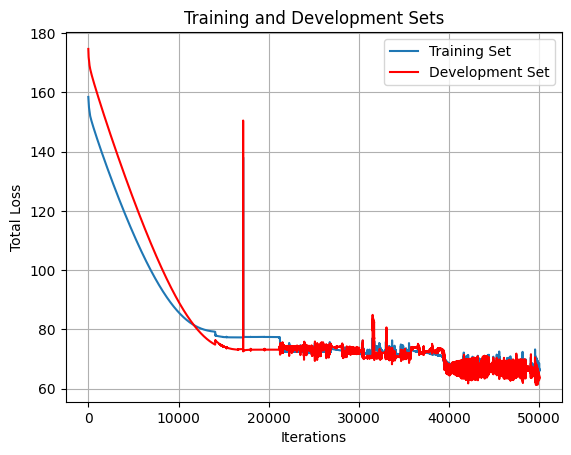

In [ ]:
# Set Model Parameters
input_dim = 8  # RB Statistics: (GP, ATT, RUSH YD, RUSH TD, TAR, REC, REC YD, REC TD)
out_dim = 1
if (out_dim == 1):
  print("Training ML Method 1 for Total Fantasy Points")
elif (out_dim == 5):
  print("Training ML Method 1 for Total Season Stats (RUSH YD, RUSH TD, REC, REC YD, REC TD)")
else: raise ValueError

# Arbitrary Parameters
width = 10
depth = 5
learning_rate = 1e-3
reg_param = 1e-5
max_epochs = 50000

# Define Loss, Model, and Optimizer
criterion = nn.MSELoss()
model = MLP(input_dim=input_dim, width=width, depth=depth, out_dim=out_dim, activation='tanh')
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_param)

# Run Training Loop
train_loss_history, dev_loss_history = train_NN1(model, optimizer, criterion, max_epochs)

# Create a single plot for training and validation sets
plt.plot(train_loss_history, label='Training Set')
plt.plot(dev_loss_history, label='Development Set', color='red')
plt.xlabel('Iterations')
plt.ylabel('Total Loss')
plt.title('Training and Development Sets')
plt.legend()
plt.grid(True)
plt.show()

Evaluating Final Model: 
Loss: 22745.765625


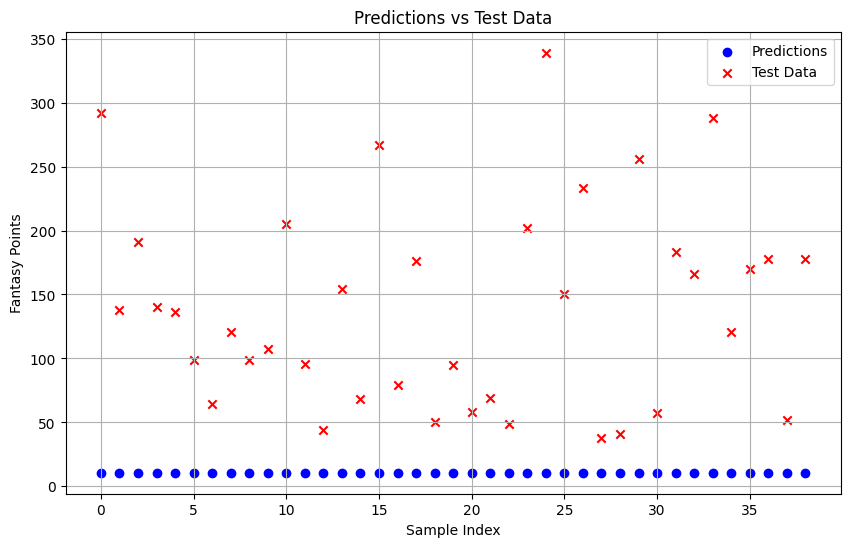

In [ ]:
# Run Testing
pred, test_loss_history = test_NN1(model, criterion)

# Squeeze the prediction and true value tensors to 1D arrays for plotting
pred_1d = pred.squeeze()
y_test_1d = y_test_tensor.squeeze()

plt.figure(figsize=(10, 6))
plt.scatter(range(len(pred_1d)), pred_1d, label='Predictions', color='blue', marker='o')
plt.scatter(range(len(y_test_1d)), y_test_1d, label='Test Data', color='red', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Fantasy Points')
plt.title('Predictions vs Test Data')
plt.legend()
plt.grid(True)
plt.show()